In [9]:
import os, glob
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import myutil.myutil as util

import evo.core.trajectory as evotraj
import evo.core.transformations as transform
import evo.core.sync as sync
import evo.core.metrics as metrics
from evo.core.metrics import PoseRelation

from PIL import Image

from ceva import Ceva

# Time to start considering the estimate
test_start = 0
test_end = 100000

mcd_seq = 'ntu_day_01'

log_path = '/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/exp_mcdviral_' + mcd_seq + '_pcd'
gtr_path = f'/media/tmn/mySataSSD1/DATASETS/MCDVIRAL/MCD_GT_REFINED/result_{mcd_seq}_refined'

# The path to the experiment log
xtrz_log = log_path + '/extrinsics_1.csv'

# The path to the trajectories
traj_est_logs = [log_path + '/gptraj_0.csv',
                 log_path + '/gptraj_1.csv']

traj_estkf_logs = [log_path + '/kf_exp/lidar_0_pose.pcd',
                   log_path + '/kf_exp/lidar_1_pose.pcd']

# The path to the trajlo logs
traj_trajlo_logs = [log_path + '/trajlo_exp/mcdouster_estimated_pose.txt',
                    log_path + '/trajlo_exp/mcdlivox_estimated_pose.txt']

# # Trajectory groundtruth error
traj_gtr_log = gtr_path + '/spline_log_3.csv'


# Lidar extrinsic
# pose_B_L = [np.array([0,  45, 0,  0,   0,  0]),
#             np.array([180, 0, 0, -0.5, 0, -0.25])]
T_B_L = [np.array([[ 0.999934655205122900,  0.003477624535771754, -0.010889970036688295, -0.060649229060416594],
                   [ 0.003587143302461965, -0.999943027982117100,  0.010053516443599904, -0.012837544242408117],
                   [-0.010854387257665576, -0.010091923381711220, -0.999890161647627000, -0.020492606896077407],
                   [ 0.000000000000000000,  0.000000000000000000,  0.000000000000000000,  0.000000000000000000]]),
         np.array([[ 0.999858131605080600, -0.000225819622877349, -0.016842377168758943, -0.010514839241742317],
                   [-0.000171114076921538, -0.999994705851753000,  0.003249459714879789, -0.008989784841758377],
                   [-0.016843021794484745, -0.003246116751423288, -0.999852876848822300,  0.037356468638334630],
                   [ 0.000000000000000000,  0.000000000000000000,  0.000000000000000000,  0.000000000000000000]]),
        ]

T_L0_L1 = util.tfmult(util.tfinv(T_B_L[0]), T_B_L[1])
Rot01 = T_L0_L1[0:3, 0:3]
Pos01 = T_L0_L1[0:3, 3]
Eul01 = np.array(util.rotm2eul(Rot01))/math.pi*180
Qua01 = np.array(util.rotm2quat(Rot01))
print("xyz", Pos01)
print("ypr", Eul01)


xyz [ 0.049517 -0.004257 -0.05835 ]
ypr [ 0.21877195 -0.34097071 -0.38992167]


In [10]:
def meta_est_log(x):
    # Read the spline
    log = open(x, 'r')

    # Extract some settings in the header
    log_header = log.readline()
    log.close()

    # # Print the header
    # print(log_header)

    # Read the dt from header
    dt = float(log_header.split(sep=';')[0].replace('Dt:', ''))
    # Read the order
    order = int(log_header.split(sep=';')[1].replace('Order:', ''))
    # Read the knots
    knots = int(log_header.split(sep=';')[2].replace('Knots:', ''))
    # Read the start time in header
    start_time = float(log_header.split(sep=';')[3].replace('MinTime:', ''))

    return (dt, order, knots, start_time)
    
def load_spline(x):

    # Read the spline
    log = open(x, 'r')

    # Extract some settings in the header
    log_header = log.readline()
    log.close()

    # # Print the header
    # print(log_header)

    # Read the dt from header
    dt = float(log_header.split(sep=',')[0].replace('Dt: ', ''))
    # Read the order
    order = int(log_header.split(sep=',')[1].replace('Order: ', ''))
    # Read the knots
    knots = int(log_header.split(sep=',')[2].replace('Knots: ', ''))
    # Read the start time in header
    start_time = float(log_header.split(sep=',')[3].replace('MinTime: ', ''))
    # Calculate the end time
    final_time = start_time + dt*(knots - order + 1)

    # print("Seq: ", log)
    # print("dt: \t\t", dt)
    # print("order: \t\t", order)
    # print("start_time: \t", start_time)
    # print("final_time: \t", final_time)
    # print("Duration: \t", final_time - start_time)

    # Read the knots in text
    knots = np.loadtxt(x, delimiter=',', skiprows=1)
    spline = Ceva(order, dt, start_time, x)

    return spline

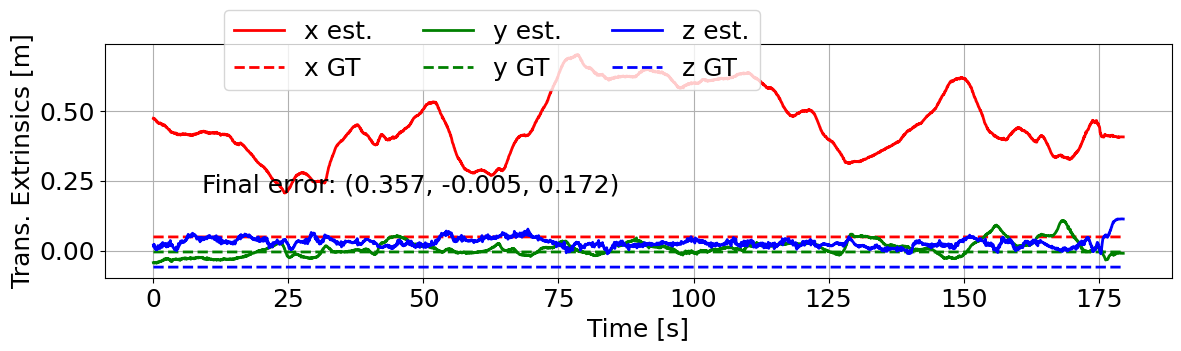

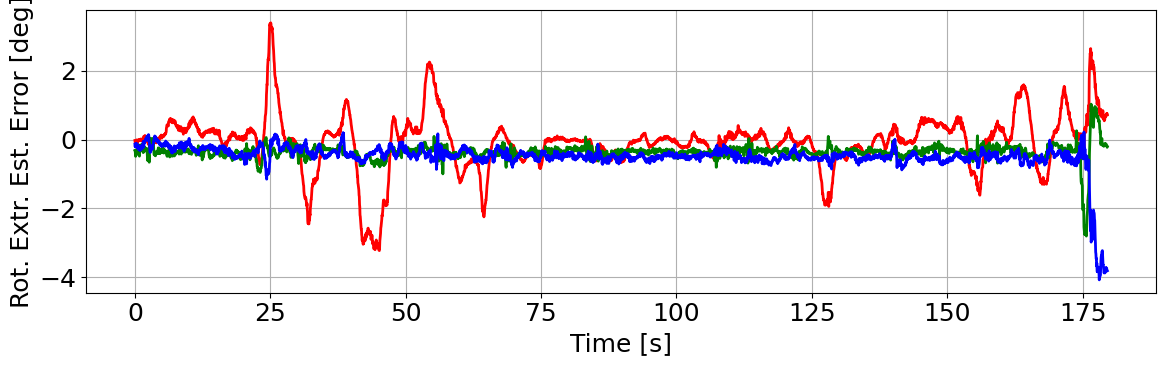

In [11]:
# Load the extrinsic data
xtrz_data = np.loadtxt(xtrz_log, delimiter=',', skiprows=1)
txtrz = xtrz_data[:, 0] - xtrz_data[0, 0]

# Calculate the position data
p_L0_L1_est = xtrz_data[:, 1:4]
p_L0_L1_err = p_L0_L1_est - Pos01

# Calculate the oritation error
Q_L0_L1_est = []
E_L0_L1_est = []
E_L0_L1_err = []
for idx in range(len(txtrz)):
    q = xtrz_data[idx, [7, 4, 5, 6]]
    Q_L0_L1_est.append(util.quat2rotm(q))
    E_L0_L1_est.append(list(util.quat2eul(q)))
    E_L0_L1_err.append(list(util.rotm2eul(Q_L0_L1_est[-1].transpose()@Rot01)))

E_L0_L1_est = np.array(E_L0_L1_est).reshape((-1, 3))
E_L0_L1_err = np.array(E_L0_L1_err).reshape((-1, 3))

# Plot the error
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

ax.plot(txtrz, p_L0_L1_est[:, 0], linewidth=2, color='r', label='x est.')
ax.plot(txtrz, np.tile(Pos01[0], reps=len(txtrz)), linewidth=2, color='r', label='x GT', linestyle='--')

ax.plot(txtrz, p_L0_L1_est[:, 1], linewidth=2, color='g', label='y est.')
ax.plot(txtrz, np.tile(Pos01[1], reps=len(txtrz)), linewidth=2, color='g', label='y GT', linestyle='--')

ax.plot(txtrz, p_L0_L1_est[:, 2], linewidth=2, color='b', label='z est.')
ax.plot(txtrz, np.tile(Pos01[2], reps=len(txtrz)), linewidth=2, color='b', label='z GT', linestyle='--')

ax.text(s=f'Final error: ({p_L0_L1_err[-1, 0]:.3f}, {p_L0_L1_err[-1, 1]:.3f}, {p_L0_L1_err[-1, 2]:.3f})', x=9, y=0.21)


# ax.set_xlim([5, 15])
ax.grid('on')
ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0.1, 1.2))

ax.set_xlabel('Time [s]')
ax.set_ylabel('Trans. Extrinsics [m]')
plt.tight_layout()
fig.savefig('trans_extrinsics_error.jpg')

# Plot the error
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

ax.plot(txtrz, E_L0_L1_err[:, 0]/np.pi*180, linewidth=2, color='r', label='yaw')
ax.plot(txtrz, E_L0_L1_err[:, 1]/np.pi*180, linewidth=2, color='g', label='pitch')
ax.plot(txtrz, E_L0_L1_err[:, 2]/np.pi*180, linewidth=2, color='b', label='raw')

ax.grid('on')
# ax.legend(ncol=3)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Rot. Extr. Est. Error [deg]')

plt.tight_layout()
fig.savefig('rot_extrinsics_error.jpg')

In [12]:
# Calculate the ATE
def calculate_metric(traj_gtr, traj_est):
    metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    metric.process_data((traj_gtr, traj_est))
    return float(metric.get_result(ref_name='reference', est_name='estimate').stats['rmse'])

traj_gtr_spline = load_spline(traj_gtr_log)

def sampleGtrTraj(timestamps):

    # Get the traj gtr
    traj_gtr = traj_gtr_spline.getPose(timestamps)

    # Transform the ground truth point to the lidar points
    t_B_L = T_B_L[lidx][:3, 3]
    R_B_L = T_B_L[lidx][0:3, 0:3]

    p_W_B = traj_gtr[:, 1:4]
    q_W_B = traj_gtr[:, [7, 4, 5, 6]]

    p_W_L = np.empty((0, 3))
    q_W_L = np.empty((0, 4))

    N = p_W_B.shape[0]
    for pidx in range(0, N):
        R_W_B = util.quat2rotm(q_W_B[pidx, :])
        q_W_L = np.append(q_W_L, [util.rotm2quat(R_W_B@R_B_L) ], axis=0)
        p_W_L = np.append(p_W_L, [p_W_B[pidx, :] + R_W_B@t_B_L], axis=0)

    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=p_W_L, orientations_quat_wxyz=q_W_L, timestamps=timestamps)

    return traj_gtr

Creating spline of order 6 and 24101 knots from log file /media/tmn/mySataSSD1/DATASETS/MCDVIRAL/MCD_GT_REFINED/result_ntu_day_01_refined/spline_log_3.csv
Done


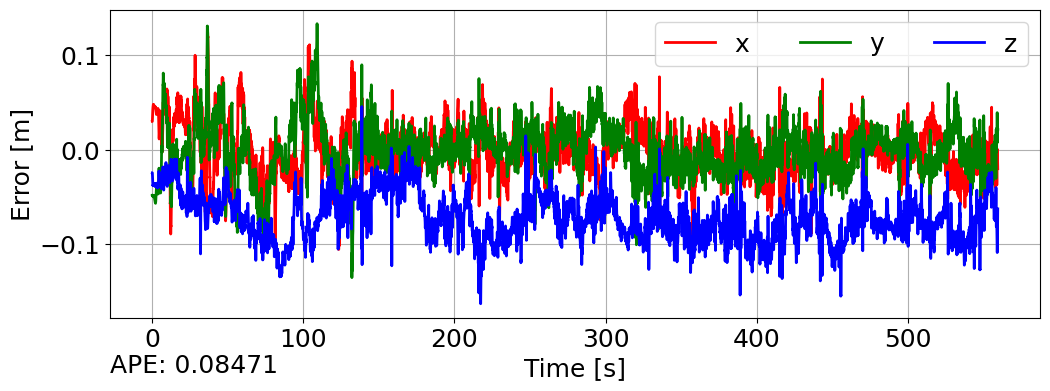

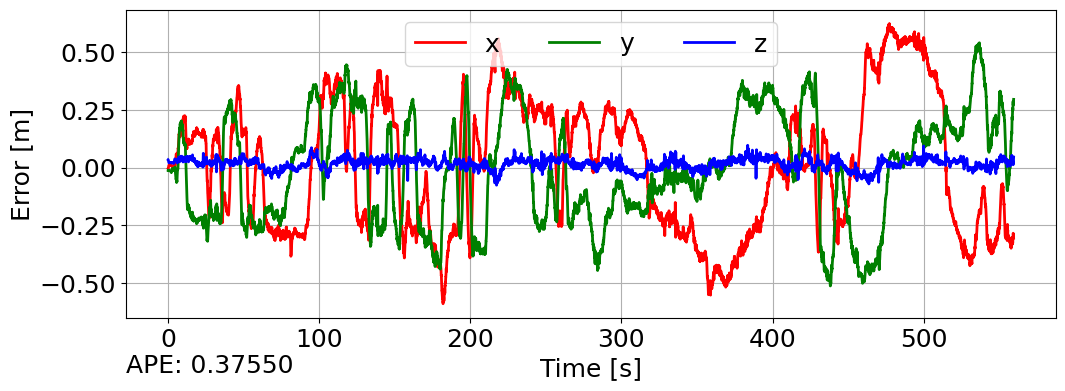

In [13]:
# Load the trajectory
traj_est_data = []
t_est_min = []
for log in traj_est_logs:
    traj_est_data.append(np.loadtxt(log, delimiter=',', skiprows=1))
    _, _, _, tmin = meta_est_log(log)
    t_est_min.append(tmin)

traj_est_viz = None
rmse_est = []

# def trim_traj(traj, tcut):
#     idxkeep = list(np.where(traj.timestamps - traj.timestamps[0] > tcut))
#     pos = traj.positions_xyz[idxkeep, :].reshape((-1, 3))
#     rot = traj.orientations_quat_wxyz[idxkeep, :].reshape((-1, 4))
#     timestamps = traj.timestamps[idxkeep].reshape((-1, 1))
#     return evotraj.PoseTrajectory3D(positions_xyz=pos, orientations_quat_wxyz=rot, timestamps=timestamps)

for lidx in range(len(traj_est_data)):
    
    # Get the traj_est
    traj_est = traj_est_data[lidx]
    tidx = list(np.where(traj_est[:, 1] > test_start)[0])
    traj_est = evotraj.PoseTrajectory3D(positions_xyz=traj_est[tidx, :][:, [12, 13, 14]], orientations_quat_wxyz=traj_est[tidx, :][:, [5, 2, 3, 4]], timestamps=traj_est[tidx, 1])

    # Get the traj gtr
    traj_gtr = sampleGtrTraj(traj_est.timestamps)
    traj_est, traj_gtr = sync.associate_trajectories(traj_est, traj_gtr, max_diff=0.2)

    # traj_est.align(traj_gtr)

    # traj_est = trim_traj(traj_est, 10.0)
    # traj_gtr = trim_traj(traj_gtr, 10.0)
    
    N = traj_est.orientations_quat_wxyz.shape[0]
    q_W_L_err = np.empty((0, 4))
    for pidx in range(0, N):
        R_W_L_est = util.quat2rotm(traj_est.orientations_quat_wxyz[pidx, :])
        R_W_L_gtr = util.quat2rotm(traj_gtr.orientations_quat_wxyz[pidx, :])
        q_W_L_err = np.append(q_W_L_err, [util.rotm2quat(R_W_L_est.transpose()@R_W_L_gtr)], axis=0)

    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_est.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=q_W_L_err, timestamps=traj_est.timestamps)
    
    # Calculate RMSE using the APE metric
    ape_metric = metrics.APE(metrics.PoseRelation.translation_part)
    ape_metric.process_data((traj_gtr, traj_est))

    # Find the RMSE
    rmse = calculate_metric(traj_est, traj_gtr)
    
    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps - traj_err.timestamps[0], traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps - traj_err.timestamps[0], traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps - traj_err.timestamps[0], traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    # ax.set_xlim([np.min(traj_est.timestamps), np.max(traj_est.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')

    if lidx == 0:
        traj_est_viz = traj_est
    rmse_est.append(rmse)


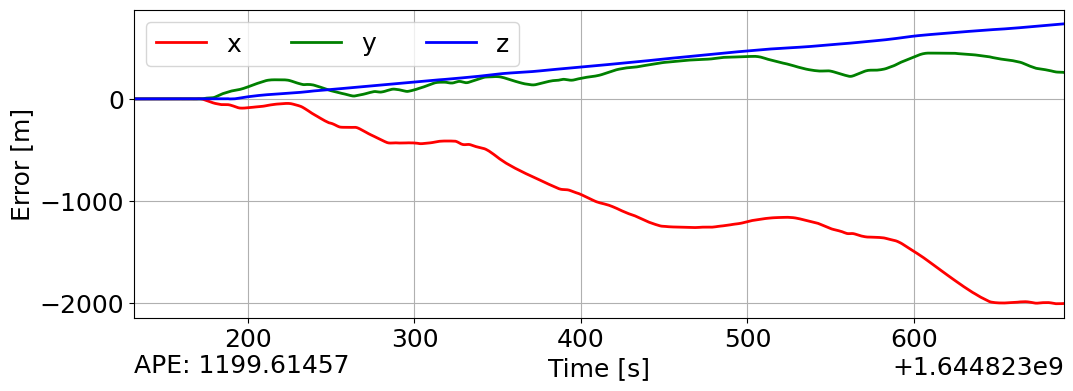

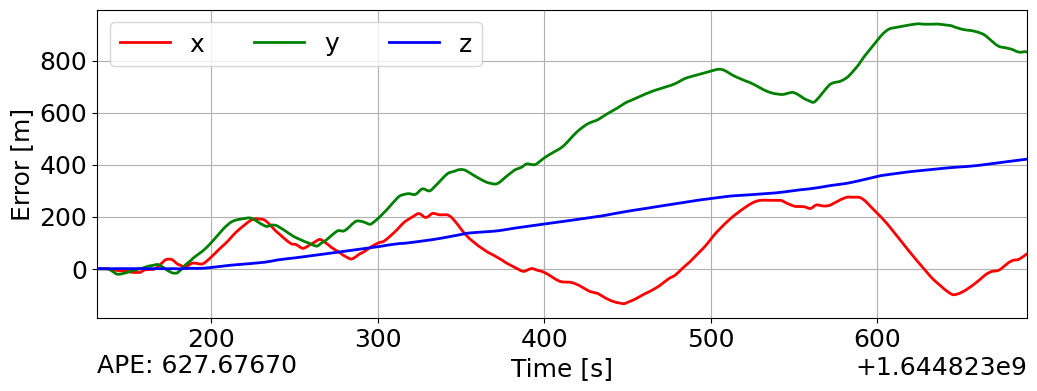

In [14]:
# Load the trajectory
traj_estkf_data = []
for log in traj_estkf_logs:
    traj_estkf_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

traj_estkf_viz = None

for lidx in range(len(traj_estkf_data)):
    
    # Get the traj_estkf
    traj_estkf = traj_estkf_data[lidx]
    tidx = list(np.where(traj_estkf[:, 4] > test_start)[0])
    traj_estkf = evotraj.PoseTrajectory3D(positions_xyz=traj_estkf[tidx, :][:, [0, 1, 2]], orientations_quat_wxyz=traj_estkf[tidx, :][:, [8, 5, 6, 7]], timestamps=traj_estkf[tidx, 4])

    # Get the traj gtr
    traj_gtr = sampleGtrTraj(traj_est.timestamps)

    traj_estkf, traj_gtr = sync.associate_trajectories(traj_estkf, traj_gtr, max_diff=0.2)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_estkf.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_estkf.orientations_quat_wxyz, timestamps=traj_estkf.timestamps)
    
    # Find the RMSE
    rmse = calculate_metric(traj_estkf, traj_gtr)
    
    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_estkf.timestamps), np.max(traj_estkf.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')

    if lidx == 0:
        traj_estkf_viz = traj_estkf

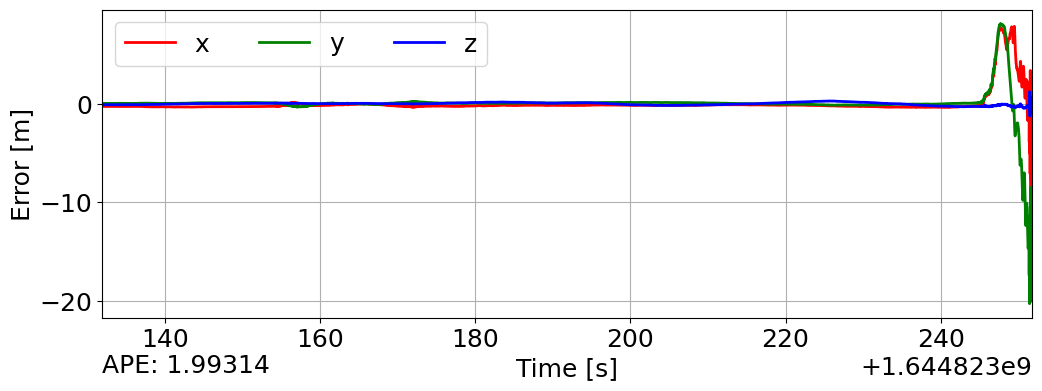

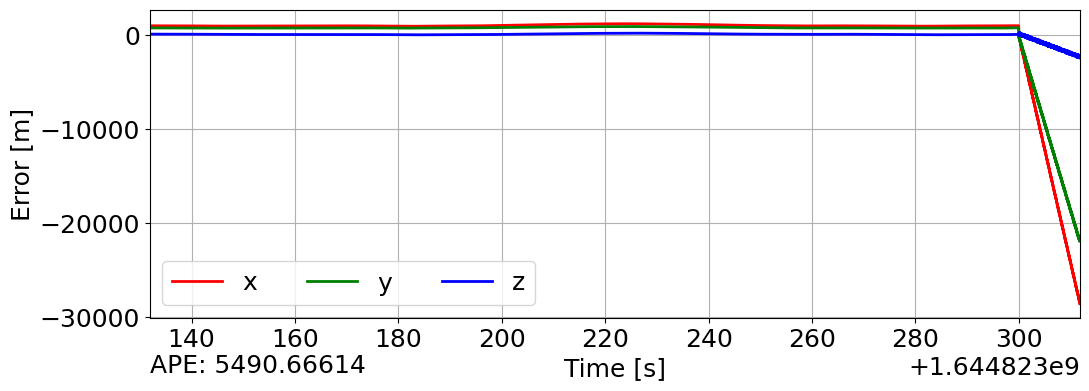

In [15]:
# Load the trajectory
traj_trajlo_data = []
for log in traj_trajlo_logs:
    traj_trajlo_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

trajlo_viz = None

for lidx in range(len(traj_trajlo_data)):
    
    # Get the traj_trajlo
    traj_trajlo = traj_trajlo_data[lidx]
    tidx = list(np.where((traj_trajlo[:, 0] - traj_trajlo[0, 0] > test_start) & (traj_trajlo[:, 0] - traj_trajlo[0, 0] < test_end))[0])
    traj_trajlo = evotraj.PoseTrajectory3D(positions_xyz=traj_trajlo[tidx, :][:, [1, 2, 3]], orientations_quat_wxyz=traj_trajlo[tidx, :][:, [7, 4, 5, 6]], timestamps=traj_trajlo[tidx, 0])

    # Get the traj gtr
    traj_gtr = traj_gtr_spline.getPose(traj_est.timestamps)

    # Transform the ground truth point to the lidar points
    t_B_L = T_B_L[lidx][:3, 3]
    R_B_L = T_B_L[lidx][0:3, 0:3]

    p_W_B = traj_gtr[:, 1:4]
    q_W_B = traj_gtr[:, [7, 4, 5, 6]]

    p_W_L = np.empty((0, 3))
    q_W_L = np.empty((0, 4))

    N = p_W_B.shape[0]
    for pidx in range(0, N):
        R_W_B = util.quat2rotm(q_W_B[pidx, :])
        q_W_L = np.append(q_W_L, [util.rotm2quat(R_W_B@R_B_L) ], axis=0)
        p_W_L = np.append(p_W_L, [p_W_B[pidx, :] + R_W_B@t_B_L], axis=0)

    # Create ground truth trajectory
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=p_W_L, orientations_quat_wxyz=q_W_L, timestamps=traj_est.timestamps)

    # Associate trajectories
    traj_trajlo, traj_gtr = sync.associate_trajectories(traj_trajlo, traj_gtr, max_diff=0.2)
    
    # Align the trajectories
    traj_trajlo.align(traj_gtr)

    # Calculate the error
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_trajlo.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_trajlo.orientations_quat_wxyz, timestamps=traj_trajlo.timestamps)
    
    # Find the RMSE
    rmse = calculate_metric(traj_trajlo, traj_gtr)
    
    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_trajlo.timestamps), np.max(traj_trajlo.timestamps)])
    # ax.set_ylim([-20, 20.0])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')

    if lidx == 0:
        trajlo_viz = traj_trajlo


/tmp/ipykernel_1309076/3498682266.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x=traj_trajlo.positions_xyz[:, 0], y=traj_trajlo.positions_xyz[:, 1], c=[1, 0.5, 0], s=2, label='Traj-LO')
/tmp/ipykernel_1309076/3498682266.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x=traj_estkf.positions_xyz[:, 0],  y=traj_estkf.positions_xyz[:, 1],  c=[0, 1.0, 0.8], s=2, label='I2EKF')


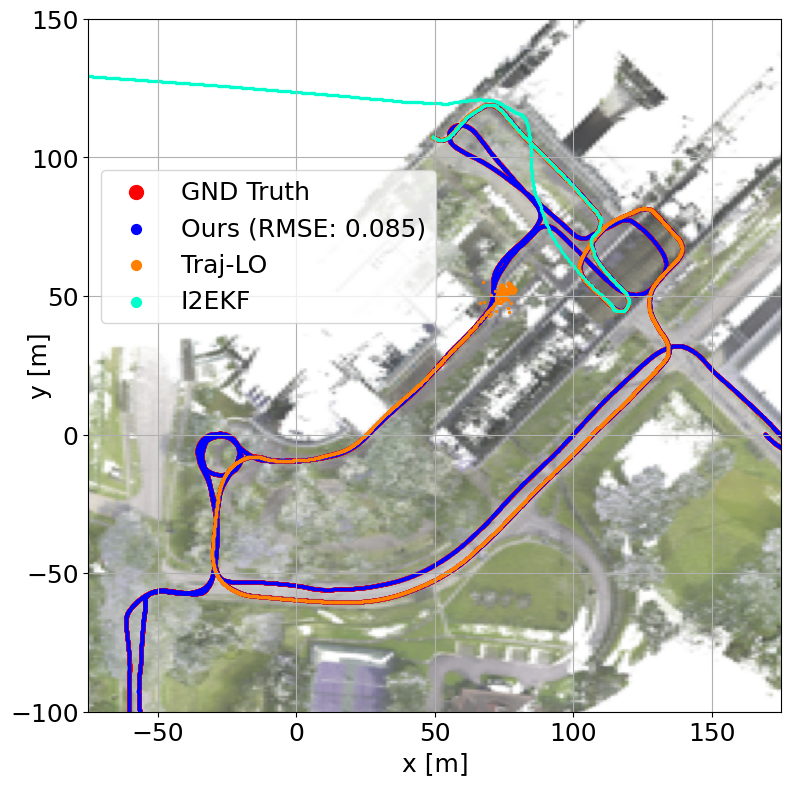

In [16]:
# Make the plot

# Get the traj_est of lidar 0
traj_est = traj_est_viz

# Get the traj_est of lidar 0
traj_estkf = traj_estkf_viz

# Get the trajlo est of ouster lidar 0
traj_trajlo = trajlo_viz

# Get the groundtruth
traj_gtr = sampleGtrTraj(traj_est.timestamps)

# Plot the trajector
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 9))

# Make the plot
img = Image.open('ntu_2d_rgb.png')
xylim = np.load('ntu_2d_rgb_xylim.npy')
# Resize the image
xspan = (xylim[0, 1] - xylim[0, 0])
yspan = (xylim[1, 1] - xylim[1, 0])
img = img.resize((int(yspan), int(xspan)))
# Load the image to the graph
x_shift = xylim[0, 0]
y_shift = xylim[1, 0]
ax.imshow(img, extent=[x_shift, img.size[1] + x_shift, y_shift, img.size[0] + y_shift], alpha=0.75)

# Configure some visuals
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

# Set the grid
ax.set_xlim([-75,  175])
ax.set_ylim([-100, 150])
ax.set_aspect('equal')
ax.grid('on')
# ax.legend()

ax.set_aspect('equal')

# Plot the trajectories
ax.scatter(x=traj_gtr.positions_xyz[:, 0],    y=traj_gtr.positions_xyz[:, 1],    c='r', s=4, label='GND Truth')
ax.scatter(x=traj_est.positions_xyz[:, 0],    y=traj_est.positions_xyz[:, 1],    c='b', s=2,  label=f'Ours (RMSE: {rmse_est[0]:.3f})')
ax.scatter(x=traj_trajlo.positions_xyz[:, 0], y=traj_trajlo.positions_xyz[:, 1], c=[1, 0.5, 0], s=2, label='Traj-LO')
ax.scatter(x=traj_estkf.positions_xyz[:, 0],  y=traj_estkf.positions_xyz[:, 1],  c=[0, 1.0, 0.8], s=2, label='I2EKF')

# for idx, rmse in enumerate(rmse_est):
#     ax.text

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]', labelpad=-30)
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.8), markerscale=5)  # Centered above the plot

fig.savefig(f'mcd_exp.jpg', bbox_inches='tight')